In [15]:
import math 
import numpy as np
import pandas as pd
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from pandas.util.testing import assert_frame_equal
from keras.models import Sequential
from keras.layers import Dense, LSTM
import datetime
plt.style.use('fivethirtyeight')

In [18]:
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end=datetime.datetime.today().strftime('%Y-%m-%d'))
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970
...,...,...,...,...,...,...
2020-04-14,288.250000,278.049988,280.000000,287.049988,48748700.0,287.049988
2020-04-15,286.329987,280.630005,282.399994,284.429993,32788600.0,284.429993
2020-04-16,288.200012,282.350006,287.380005,286.690002,38845800.0,286.690002


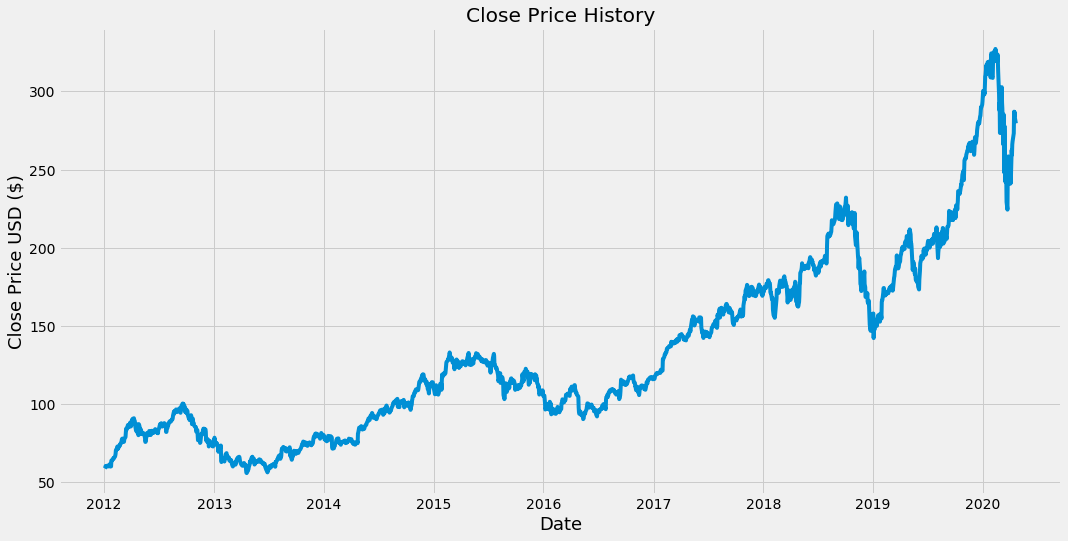

In [19]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [27]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil( len(dataset) * .8 )

training_data_len

1670

In [28]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01089548],
       [0.01205872],
       [0.01447467],
       ...,
       [0.85074239],
       [0.83640978],
       [0.82450903]])

In [33]:
train_data = scaled_data[0:training_data_len , :]

X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])

In [34]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [36]:
#Reshape the data because LSTM needs 3d array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1610, 60, 1)

In [37]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

In [38]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1610/1610 [==============================] - 56s 35ms/step - loss: 6.7616e-04


In [77]:
test_data = scaled_data[training_data_len - 60:, :]
X_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    

In [78]:
X_test = np.array(X_test)
X_test.shape

(417, 60)

In [79]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1 ))

In [80]:
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)

In [81]:
rmse=np.sqrt(np.mean(((pred - y_test)**2)))
rmse

8.85341665557862

D:\anaconda\new_anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


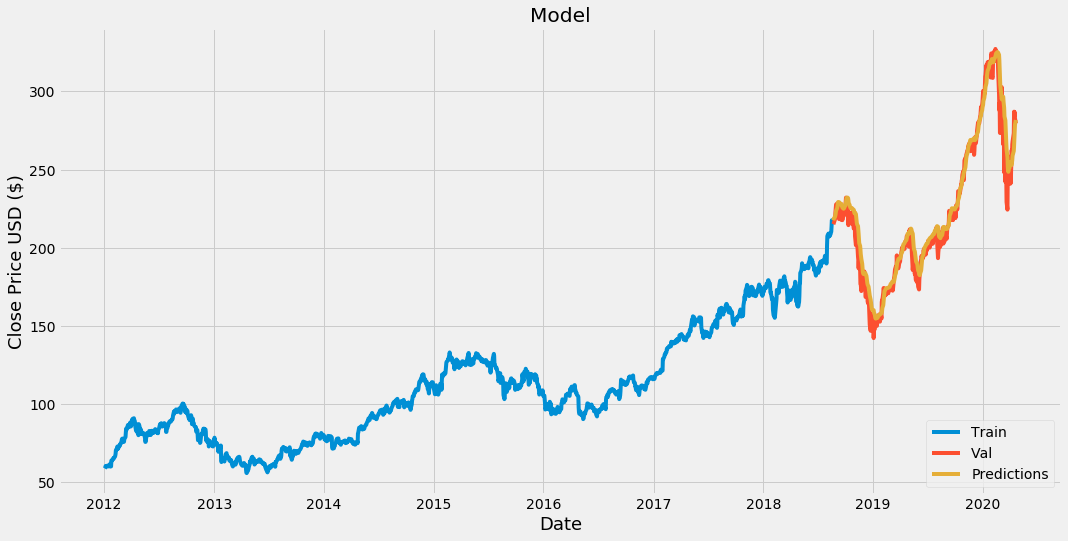

In [83]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = pred
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [84]:
valid

,Close,Predictions
Date,,
2018-08-22,215.050003,217.545837
2018-08-23,215.490005,218.299393
2018-08-24,216.160004,218.899490
2018-08-27,217.940002,219.435196
2018-08-28,219.699997,220.092148
...,...,...
2020-04-14,287.049988,265.336426
2020-04-15,284.429993,270.202606
2020-04-16,286.690002,274.730713


In [117]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2020-04-17')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
# #Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[281.72815]]


In [120]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-04-18', end='2020-04-20')
print(apple_quote2['Close'])

Date
2020-04-17    282.799988
2020-04-20    280.070007
Name: Close, dtype: float64


,Close
Date,
2012-01-03,58.747143
2012-01-04,59.062859
2012-01-05,59.718571
2012-01-06,60.342857
2012-01-09,60.247143
...,...
2020-04-14,287.049988
2020-04-15,284.429993
2020-04-16,286.690002
